# Bias correction of numerical prediction model temperature forecast Dataset

URL: http://archive.ics.uci.edu/ml/machine-learning-databases/00514/

## Content

1) [Data preprocessing](#dataproc)

2) [Model training and evaluation](#train) 

2.a) [Random Forest](#rf)
    
2.b) [Linear regression](#linear)

2.c) [Lasso Regression](#lasso)

2.d) [kNN](#knn)

---

In [1]:
# Basic imports
import sys
import math
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

print(sys.executable)

# models for random forest
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# models for linear regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# models for Lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# models for kNN
from sklearn.neighbors import KNeighborsRegressor

# statistic tools
from sklearn import metrics
from statistics import stdev
from sklearn.model_selection import GridSearchCV

# preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7


---
# 1) Data preprocessing
---

In [2]:
# Might be good idea to have a function for dataset analysis --> standardized output
# Just a prototype/idea for now
def analyse_dataset(frame, name='not-given'):
    print(f"Analysis of <{name}>")
    print('-'*40)
    print("Info:")
    print(frame.info())
    print('-'*40)
    print("Shape:")
    print(frame.shape)
    print('-'*40)
    print("Index:")
    print(frame.index)
    print('-'*40)
    print("Columns:")
    print(frame.columns)

In [3]:
dataset_name = 'Bias_correction_ucl.csv'
print("Opening: ", dataset_name)
df = pd.read_csv(dataset_name,  sep = ',')#, header = 0)
print(df)

Opening:  Bias_correction_ucl.csv
      station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  \
0         1.0  2013-06-30          28.7          21.4    58.255688   
1         2.0  2013-06-30          31.9          21.6    52.263397   
2         3.0  2013-06-30          31.6          23.3    48.690479   
3         4.0  2013-06-30          32.0          23.4    58.239788   
4         5.0  2013-06-30          31.4          21.9    56.174095   
...       ...         ...           ...           ...          ...   
7747     23.0  2017-08-30          23.3          17.1    26.741310   
7748     24.0  2017-08-30          23.3          17.7    24.040634   
7749     25.0  2017-08-30          23.2          17.4    22.933014   
7750      NaN         NaN          20.0          11.3    19.794666   
7751      NaN         NaN          37.6          29.9    98.524734   

      LDAPS_RHmax  LDAPS_Tmax_lapse  LDAPS_Tmin_lapse   LDAPS_WS    LDAPS_LH  \
0       91.116364         28.074101         2

In [4]:
# Quick analysis
print(f"Analysis of <{dataset_name}>")
print('-'*40)
print("Info:")
print(df.info())

print("Columns:")
print(df.columns)

Analysis of <Bias_correction_ucl.csv>
----------------------------------------
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAP

In [5]:
col_dict = {c: i for i, c in enumerate(df.columns)}

## Description of data columns

1. station - used weather station number: 1 to 25 
2. Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30') 
3. Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6 
4. Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9 
5. LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5 
6. LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100 
7. LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5 
8. LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6 
9. LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9 
10. LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4 
11. LDAPS_CC1 - LDAPS model forecast of next-day 1st 6-hour split average cloud cover (0-5 h) (%): 0 to 0.97 
12. LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97 
13. LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98 
14. LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97 
15. LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7 
16. LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6 
17. LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (12-17 h) (%): 0 to 15.8 
18. LDAPS_PPT4 - LDAPS model forecast of next-day 4th 6-hour split average precipitation (18-23 h) (%): 0 to 16.7 
19. lat - Latitude (Â°): 37.456 to 37.645 
20. lon - Longitude (Â°): 126.826 to 127.135 
21. DEM - Elevation (m): 12.4 to 212.3 
22. Slope - Slope (Â°): 0.1 to 5.2 
23. Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9 
24. Next_Tmax - The next-day maximum air temperature (Â°C): 17.4 to 38.9 
25. Next_Tmin - The next-day minimum air temperature (Â°C): 11.3 to 29.8

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

## First look on data and information

In [7]:
display_all(df.tail().transpose())
print('#'*40)
display('Some more info')
print('#'*40)
display(df.info())

7747        7748         7749       7750      7751
station                   23          24           25        NaN       NaN
Date              2017-08-30  2017-08-30   2017-08-30        NaN       NaN
Present_Tmax            23.3        23.3         23.2         20      37.6
Present_Tmin            17.1        17.7         17.4       11.3      29.9
LDAPS_RHmin          26.7413     24.0406       22.933    19.7947   98.5247
LDAPS_RHmax          78.8699      77.295      77.2437    58.9363       100
LDAPS_Tmax_lapse     26.3521     27.0102      27.9395     17.625   38.5423
LDAPS_Tmin_lapse     18.7757     18.7335       18.523    14.2726   29.6193
LDAPS_WS             6.14892     6.54282      7.28926    2.88258   21.8576
LDAPS_LH             72.0583     47.2415      9.09003   -13.6032   213.414
LDAPS_CC1          0.0300342   0.0358738    0.0489535          0  0.967277
LDAPS_CC2           0.081035   0.0749624    0.0598686          0  0.968353
LDAPS_CC3                  0           0            0          0  0.983789
LDAPS_CC4                  0           0  0.000796153          0   0.97471
LDAPS_PPT1                 0           0            0          0   23.7015
LDAPS_PPT2                 0           0            0          0   21.6217
LDAPS_PPT3                 0           0            0          0   15.8412
LDAPS_PPT4                 0           0            0          0   16.6555
lat                  37.5372     37.5237      37.5237    37.4562    37.645
lon                  126.891     126.909       126.97    126.826   127.135
DEM                  15.5876     17.2956      19.5844      12.37   212.335
Slope                 0.1554      0.2223       0.2713  0.0984746   5.17823
Solar radiation      4443.31     4438.37      4451.35    4329.52    5992.9
Next_Tmax               28.3        28.6         27.8       17.4      38.9
Next_Tmin               18.1        18.8         17.4       11.3      29.8

########################################


'Some more info'

########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  L

None

In [8]:
# Split into train and test
def split_simple(df, n): 
    '''n... number to split at'''
    return df[:n].copy(), df[n:].copy()

In [9]:
df_prep_rf = df
cols_to_drop = ['station', 'Date', 'Next_Tmax']
df_prep_rf = df_prep_rf.drop(cols_to_drop, axis=1)
np.where(np.isnan(df_prep_rf))

(array([ 225,  225,  271, ..., 7682, 7707, 7707]),
 array([ 0,  1,  0, ..., 21,  0,  1]))

In [10]:
# Fix missing values
from sklearn.impute import SimpleImputer
np.where(np.isnan(df_prep_rf))

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

df_imputed = imp.fit_transform(df_prep_rf)
df_prep_rf = pd.DataFrame(df_imputed, columns=df_prep_rf.columns)
np.where(np.isnan(df_prep_rf))

(array([], dtype=int64), array([], dtype=int64))

In [11]:
display(df_prep_rf.columns.values)
display(df_prep_rf.index)

array(['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM',
       'Slope', 'Solar radiation', 'Next_Tmin'], dtype=object)

RangeIndex(start=0, stop=7752, step=1)

In [12]:
display(df_prep_rf)

Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  LDAPS_Tmax_lapse  \
0             28.7          21.4    58.255688    91.116364         28.074101   
1             31.9          21.6    52.263397    90.604721         29.850689   
2             31.6          23.3    48.690479    83.973587         30.091292   
3             32.0          23.4    58.239788    96.483688         29.704629   
4             31.4          21.9    56.174095    90.155128         29.113934   
...            ...           ...          ...          ...               ...   
7747          23.3          17.1    26.741310    78.869858         26.352081   
7748          23.3          17.7    24.040634    77.294975         27.010193   
7749          23.2          17.4    22.933014    77.243744         27.939516   
7750          20.0          11.3    19.794666    58.936283         17.624954   
7751          37.6          29.9    98.524734   100.000153         38.542255   

      LDAPS_Tmin_lapse   LDAPS_WS    LDAPS_LH  LDAPS_CC1  LDAPS_CC2  ...  \
0            23.006936   6.818887   69.451805   0.233947   0.203896  ...   
1            24.035009   5.691890   51.937448   0.225508   0.251771  ...   
2            24.565633   6.138224   20.573050   0.209344   0.257469  ...   
3            23.326177   5.650050   65.727144   0.216372   0.226002  ...   
4            23.486480   5.735004  107.965535   0.151407   0.249995  ...   
...                ...        ...         ...        ...        ...  ...   
7747         18.775678   6.148918   72.058294   0.030034   0.081035  ...   
7748         18.733519   6.542819   47.241457   0.035874   0.074962  ...   
7749         18.522965   7.289264    9.090034   0.048954   0.059869  ...   
7750         14.272646   2.882580  -13.603212   0.000000   0.000000  ...   
7751         29.619342  21.857621  213.414006   0.967277   0.968353  ...   

      LDAPS_PPT1  LDAPS_PPT2  LDAPS_PPT3  LDAPS_PPT4      lat      lon  \
0       0.000000    0.000000    0.000000    0.000000  37.6046  126.991   
1       0.000000    0.000000    0.000000    0.000000  37.6046  127.032   
2       0.000000    0.000000    0.000000    0.000000  37.5776  127.058   
3       0.000000    0.000000    0.000000    0.000000  37.6450  127.022   
4       0.000000    0.000000    0.000000    0.000000  37.5507  127.135   
...          ...         ...         ...         ...      ...      ...   
7747    0.000000    0.000000    0.000000    0.000000  37.5372  126.891   
7748    0.000000    0.000000    0.000000    0.000000  37.5237  126.909   
7749    0.000000    0.000000    0.000000    0.000000  37.5237  126.970   
7750    0.000000    0.000000    0.000000    0.000000  37.4562  126.826   
7751   23.701544   21.621661   15.841235   16.655469  37.6450  127.135   

           DEM     Slope  Solar radiation  Next_Tmin  
0     212.3350  2.785000      5992.895996       21.2  
1      44.7624  0.514100      5869.312500       22.5  
2      33.3068  0.266100      5863.555664       23.9  
3      45.7160  2.534800      5856.964844       24.3  
4      35.0380  0.505500      5859.552246       22.5  
...        ...       ...              ...        ...  
7747   15.5876  0.155400      4443.313965       18.1  
7748   17.2956  0.222300      4438.373535       18.8  
7749   19.5844  0.271300      4451.345215       17.4  
7750   12.3700  0.098475      4329.520508       11.3  
7751  212.3350  5.178230      5992.895996       29.8  

[7752 rows x 22 columns]

In [13]:
df_rf = df_prep_rf

<Figure size 432x288 with 0 Axes>

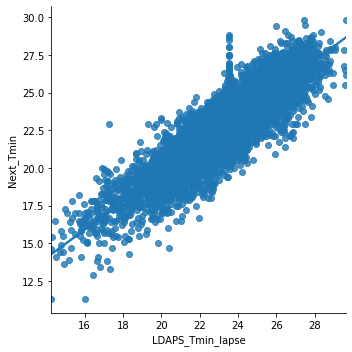

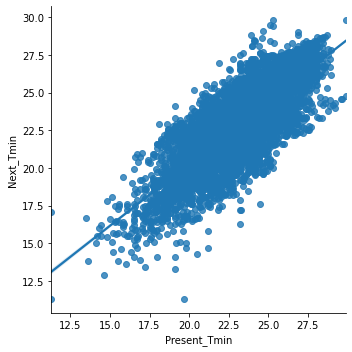

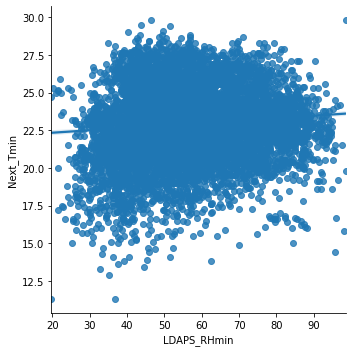

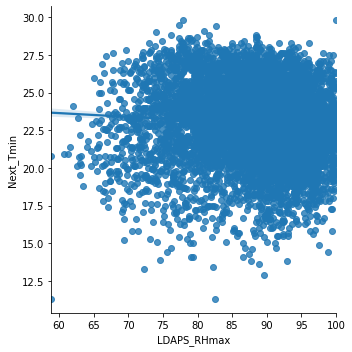

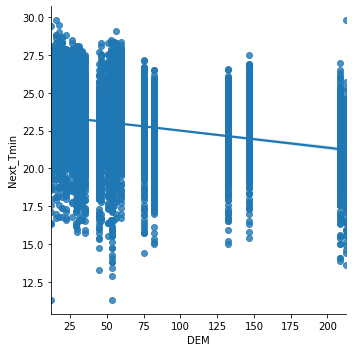

In [14]:
plt.figure()
sns.lmplot("LDAPS_Tmin_lapse","Next_Tmin",df_prep_rf)

sns.lmplot("Present_Tmin","Next_Tmin",df_prep_rf)

sns.lmplot("LDAPS_RHmin","Next_Tmin",df_prep_rf)

sns.lmplot("LDAPS_RHmax","Next_Tmin",df_prep_rf)

sns.lmplot("DEM","Next_Tmin",df_prep_rf)

---
# 2. Model training and evaluation
---

# a) Random forest

In [15]:
# Feature importance
from prettytable import PrettyTable as PT # pip install PTable
def print_RF_featureImportance(rf, X):
    table = PT()
    table.field_names = ['Feature', 'Score', 'Comment']
    for name, score in zip(X.columns.values, rf.feature_importances_):
        print(f"{name}: {score:.5f}\t\t... {col_dict[name]}")
        table.add_row([name, round(score, ndigits=4), col_dict[name]])
    print(table)

def print_GridSearchResult(grid):
    print(grid.best_params_)
    print(grid.best_estimator_)

In [16]:
# Split for random forest

rnd_state = 42
ratio = 0.2 # test/num_samples
#####
num_instances, _ = df_rf.shape
print(f"From {num_instances} using {num_instances*ratio:.0f} for testing and {num_instances*(1-ratio):.0f} for training. Ratio = {ratio*100:.2f}%")
X, y = (df_rf.drop(['Next_Tmin'], axis=1), df_rf.Next_Tmin)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ratio, random_state = rnd_state)
display(X_test)


From 7752 using 1550 for testing and 6202 for training. Ratio = 20.00%


Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  LDAPS_Tmax_lapse  \
5082          22.6          20.4    58.767471    92.432762         27.738858   
5597          35.0          28.0    63.308525    84.527557         31.884129   
1623          30.4          23.6    76.827095    87.603271         23.548905   
6821          28.0          25.7    47.731480    88.783661         33.380138   
3892          33.0          26.5    67.170654    90.186317         30.283875   
...            ...           ...          ...          ...               ...   
4838          28.3          20.4    43.729088    76.447403         32.676940   
6636          28.6          24.4    56.873791    84.853401         30.755015   
5369          29.7          26.2    78.213020    98.838699         29.586551   
2789          23.6          20.0    68.897232    95.118340         25.744147   
4050          31.4          23.1    76.807426    96.652817         27.554953   

      LDAPS_Tmin_lapse   LDAPS_WS    LDAPS_LH  LDAPS_CC1  LDAPS_CC2  ...  \
5082         20.461129   4.795663   46.229816   0.347618   0.183488  ...   
5597         27.795744   5.584913  100.422219   0.363395   0.191068  ...   
1623         21.463488   6.629432   66.126115   0.698366   0.630009  ...   
6821         25.709458   5.568819   89.576574   0.206988   0.342325  ...   
3892         25.515777   7.171682   77.769132   0.677158   0.581042  ...   
...                ...        ...         ...        ...        ...  ...   
4838         24.263681   6.362155   15.082080   0.108359   0.020878  ...   
6636         23.758643   6.146817   16.834534   0.217765   0.172556  ...   
5369         22.994015  10.830304   75.701864   0.782048   0.681032  ...   
2789         20.965718   5.332390   39.705182   0.912933   0.862675  ...   
4050         23.007233   7.612918   50.460918   0.490416   0.652233  ...   

      LDAPS_CC4  LDAPS_PPT1  LDAPS_PPT2  LDAPS_PPT3  LDAPS_PPT4      lat  \
5082   0.001978    0.004592    0.001633    0.000000    0.000000  37.4697   
5597   0.067232    0.975154    0.000000    0.000207    0.000000  37.5372   
1623   0.416622    0.356914    0.069469    0.248547    0.005955  37.5237   
6821   0.063128    0.000000    0.000000    0.000000    0.000000  37.5102   
3892   0.213825    0.000000    0.003209    0.000000    0.000000  37.4832   
...         ...         ...         ...         ...         ...      ...   
4838   0.043744    0.000000    0.000000    0.000000    0.000000  37.4967   
6636   0.124229    0.000000    0.000000    0.000000    0.000000  37.5507   
5369   0.471470    1.222988    8.604322    0.014133    0.589755  37.6181   
2789   0.368405    1.712988    2.662846    0.010695    0.000000  37.5507   
4050   0.384574    2.749202    2.009587    0.030672    0.000000  37.6046   

          lon       DEM   Slope  Solar radiation  
5082  126.910   52.5180  1.5629      5673.949219  
5597  126.891   15.5876  0.1554      5228.443848  
1623  126.909   17.2956  0.2223      5838.980469  
6821  127.086   21.9668  0.1332      5560.201660  
3892  127.024   56.4448  1.2313      5413.949219  
...       ...       ...     ...              ...  
4838  126.927   30.9680  0.6180      5798.291504  
6636  126.988  132.1180  0.5931      5751.119141  
5369  127.004  146.5540  4.7296      5547.700195  
2789  126.937   30.0464  0.8552      4912.248535  
4050  126.991  212.3350  2.7850      5388.140137  

[1551 rows x 21 columns]

In [17]:
# Simple training of RFRegressor
before = 0
n_cores = 2
rf_model = RandomForestRegressor(n_jobs=n_cores)

rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
error = math.sqrt(metrics.mean_squared_error(y_test, pred))

print("Model performance:")
print("RMSE: {}".format(error))
print("R^2-score: {}".format(rf_model.score(X_test, y_test)))

Model performance:
RMSE: 0.7643773098267564
R^2-score: 0.9062409413179147


In [18]:
print_RF_featureImportance(rf_model, X_train)

Present_Tmax: 0.01673		... 2
Present_Tmin: 0.06157		... 3
LDAPS_RHmin: 0.00937		... 4
LDAPS_RHmax: 0.00835		... 5
LDAPS_Tmax_lapse: 0.00798		... 6
LDAPS_Tmin_lapse: 0.76926		... 7
LDAPS_WS: 0.01366		... 8
LDAPS_LH: 0.00690		... 9
LDAPS_CC1: 0.01157		... 10
LDAPS_CC2: 0.00922		... 11
LDAPS_CC3: 0.01057		... 12
LDAPS_CC4: 0.01290		... 13
LDAPS_PPT1: 0.00551		... 14
LDAPS_PPT2: 0.00456		... 15
LDAPS_PPT3: 0.00314		... 16
LDAPS_PPT4: 0.00415		... 17
lat: 0.00719		... 18
lon: 0.00812		... 19
DEM: 0.00879		... 20
Slope: 0.00739		... 21
Solar radiation: 0.01305		... 22
+------------------+--------+---------+
|     Feature      | Score  | Comment |
+------------------+--------+---------+
|   Present_Tmax   | 0.0167 |    2    |
|   Present_Tmin   | 0.0616 |    3    |
|   LDAPS_RHmin    | 0.0094 |    4    |
|   LDAPS_RHmax    | 0.0083 |    5    |
| LDAPS_Tmax_lapse | 0.008  |    6    |
| LDAPS_Tmin_lapse | 0.7693 |    7    |
|     LDAPS_WS     | 0.0137 |    8    |
|     LDAPS_LH     | 0.0069 |  

In [19]:
rf_model_prediction = rf_model.predict(X_test)

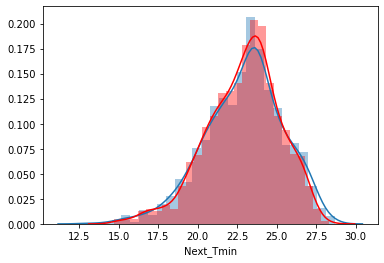

In [20]:
sns.distplot(y_test)
sns.distplot(rf_model_prediction, color="red")

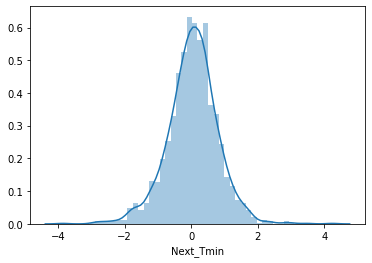

In [21]:
sns.distplot(y_test-rf_model_prediction)

In [22]:
n_cores = 2
number_of_trees = 500 # default = 100
rf = RandomForestRegressor(n_jobs=n_cores, n_estimators=number_of_trees, bootstrap=True) #, verbose=1)

rf.fit(X_train, y_train)
print("Model performance:")
print("RMSE: {}".format(error))
print("R^2-score: {}".format(rf_model.score(X_test, y_test)))

print("Feature importance")
print_RF_featureImportance(rf, X_train)
rf_RD = rf

Model performance:
RMSE: 0.7643773098267564
R^2-score: 0.9062409413179147
Feature importance
Present_Tmax: 0.01641		... 2
Present_Tmin: 0.06218		... 3
LDAPS_RHmin: 0.00931		... 4
LDAPS_RHmax: 0.00818		... 5
LDAPS_Tmax_lapse: 0.00784		... 6
LDAPS_Tmin_lapse: 0.76852		... 7
LDAPS_WS: 0.01368		... 8
LDAPS_LH: 0.00700		... 9
LDAPS_CC1: 0.01187		... 10
LDAPS_CC2: 0.00950		... 11
LDAPS_CC3: 0.01047		... 12
LDAPS_CC4: 0.01296		... 13
LDAPS_PPT1: 0.00536		... 14
LDAPS_PPT2: 0.00444		... 15
LDAPS_PPT3: 0.00290		... 16
LDAPS_PPT4: 0.00418		... 17
lat: 0.00718		... 18
lon: 0.00810		... 19
DEM: 0.00886		... 20
Slope: 0.00749		... 21
Solar radiation: 0.01357		... 22
+------------------+--------+---------+
|     Feature      | Score  | Comment |
+------------------+--------+---------+
|   Present_Tmax   | 0.0164 |    2    |
|   Present_Tmin   | 0.0622 |    3    |
|   LDAPS_RHmin    | 0.0093 |    4    |
|   LDAPS_RHmax    | 0.0082 |    5    |
| LDAPS_Tmax_lapse | 0.0078 |    6    |
| LDAPS_Tmin_lapse

In [23]:
rfRD_prediction = rf_RD.predict(X_test)

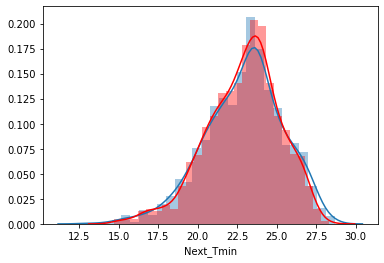

In [24]:
sns.distplot(y_test)
sns.distplot(rf_model_prediction, color="red")

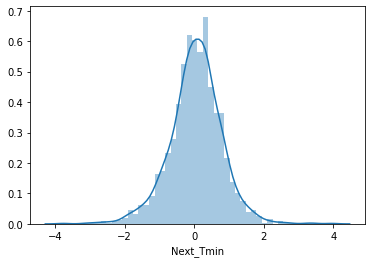

In [25]:
sns.distplot(y_test-rfRD_prediction)

## Optimize Hyperparameters via GridSearch


## Notes on the RandomForestRegressor from scikit-learn
-----
The default values for the parameters controlling the size of the trees
(e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and
unpruned trees which can potentially be very large on some data sets. To
reduce memory consumption, the complexity and size of the trees should be
controlled by setting those parameter values.

## Number of variables/features per tree --> 'max_features'

A good starting point is/might be: *the square root of the number of features presented to the tree*. Then, test some values below and above that starting point.

## Number of trees in the forest --> 'n_estimators'

The more the merrier

In [ ]:
from numpy import sqrt
num_features = X.shape[1]
print(num_features)
sqrt_num_features = round(sqrt(num_features), 0)
sqrt_num_features

In [ ]:
n_cores = 2
# brute forcing
param_grid = [
    {
        'n_estimators': [10, 30, 100], 'max_features': [i for i in range(3, 7)]
    }
#,{'bootstrap': [False], 'n_estimators': [3, 30, 100], 'max_features': [3, 4, 5, 6]},
]
k = 10
forest_reg = RandomForestRegressor(n_jobs=n_cores)
grid_search = GridSearchCV(forest_reg, param_grid, n_jobs=n_cores , cv=k, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

In [ ]:
print_GridSearchResult(grid_search)
grid_search.scorer_
scores = grid_search.score(X_test, y_test)
pred = grid_search.predict(X_test)
error = math.sqrt(metrics.mean_squared_error(y_test, pred))

print("Model performance:")
print("RMSE: {}".format(error))
print("R^2-score: {}".format(grid_search.score(X_test, y_test)))

---
# b) Linear regression
---

In [26]:
df_lin = df_prep_rf

In [27]:
linreg = LinearRegression(normalize=True)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

Model performance:
RMSE: 0.9818378084004215
R^2-score: 0.8453046823462249


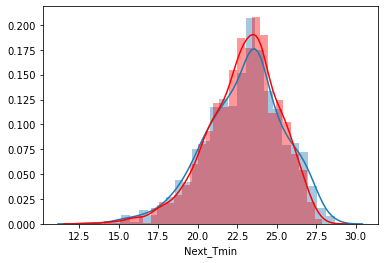

In [45]:
linreg.coef_

pred_linreg = linreg.predict(X_test)
error = math.sqrt(metrics.mean_squared_error(y_test, pred_linreg))

print("Model performance:")
print("RMSE: {}".format(error))
print("R^2-score: {}".format(linreg.score(X_test, y_test)))

sns.distplot(y_test)
sns.distplot(pred_linreg, color='red')

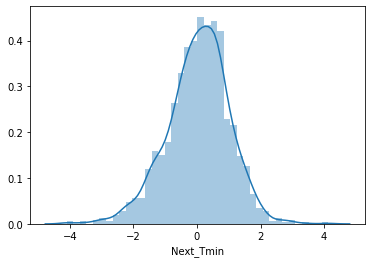

In [46]:
sns.distplot(y_test-pred_linreg)

---
# c) Lasso Regression
---

In [29]:
lasso = Lasso(normalize = True)
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error',cv = 5)

In [30]:
lasso_regressor.fit(X_train,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1e-08}
-1.0771102592532196


In [31]:
y_lasso_pred = lasso_regressor.predict(X_test)

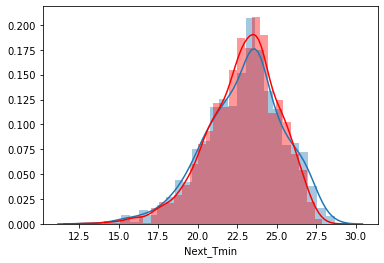

In [42]:
sns.distplot(y_test)
sns.distplot(y_lasso_pred, color='red')

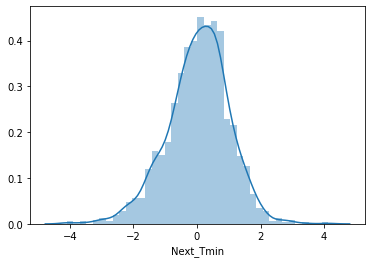

In [41]:
sns.distplot(y_test-y_lasso_pred)

---
# d) kNN
---

In [33]:
df_knn = df_prep_rf

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

X_train_knn_scaled = scaler.fit_transform(X_train)
X_train_knn = pd.DataFrame(X_train_knn_scaled)

X_test_knn_scaled = scaler.fit_transform(X_test)
X_test_knn = pd.DataFrame(X_test_knn_scaled)

In [34]:
rmse_val_knn = [] # to store rmse values for different k
for k in range(35):
    k = k + 1
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_knn, y_train)
    pred = model.predict(X_test_knn)
    error = math.sqrt(metrics.mean_squared_error(y_test, pred))
    rmse_val_knn.append(error)
    print("RMSE for k={}: {}".format(k, error))
    print("R^2 for k={}: {}\n".format(k, model.score(X_test_knn, y_test)))

RMSE for k=1: 1.2146435193573817
R^2 for k=1: 0.7632470823882425

RMSE for k=2: 1.0564007464991036
R^2 for k=2: 0.8209167102143056

RMSE for k=3: 0.9821909144270027
R^2 for k=3: 0.8451933937588809

RMSE for k=4: 0.9547631571701589
R^2 for k=4: 0.8537186469346247

RMSE for k=5: 0.9345947103920778
R^2 for k=5: 0.859833476332077

RMSE for k=6: 0.9360556966799545
R^2 for k=6: 0.8593949088396932

RMSE for k=7: 0.9472156584042599
R^2 for k=7: 0.8560222433342335

RMSE for k=8: 0.9611254153855512
R^2 for k=8: 0.8517626003066748

RMSE for k=9: 0.9740188603551524
R^2 for k=9: 0.8477587301454143

RMSE for k=10: 0.9786667939361897
R^2 for k=10: 0.846302299146334

RMSE for k=11: 0.9876002443689836
R^2 for k=11: 0.8434835307344557

RMSE for k=12: 0.9967256704374464
R^2 for k=12: 0.8405777434425437

RMSE for k=13: 1.0091215204360602
R^2 for k=13: 0.836587753308617

RMSE for k=14: 1.0123010834916573
R^2 for k=14: 0.8355563649507283

RMSE for k=15: 1.0197173819124838
R^2 for k=15: 0.833138051942357

RM

Text(0, 0.5, 'RMSE')

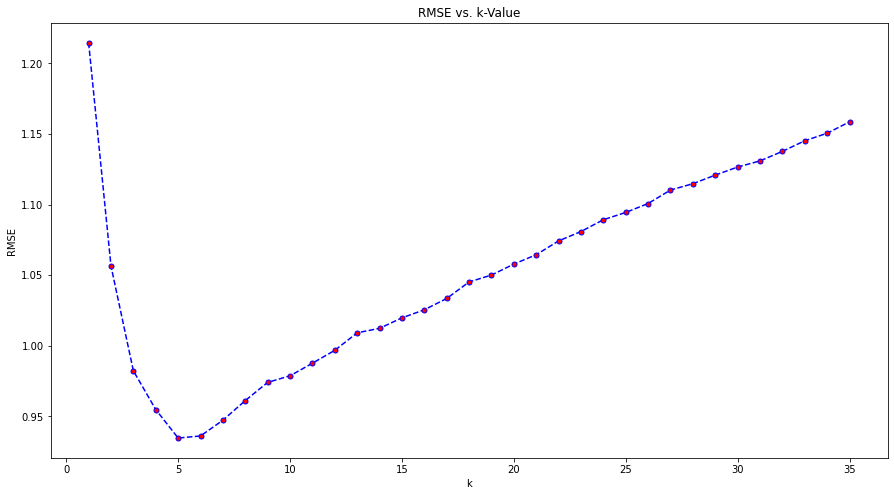

In [39]:
plt.figure(figsize=(15,8))
plt.plot(range(1,36), rmse_val_knn, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=5)
plt.title('RMSE vs. k-Value')
plt.xlabel('k')
plt.ylabel('RMSE')

## Optimizing kNN-search for optimal k-Value via Gridsearch

In [36]:
params = {'n_neighbors': range(1, 35)}

knn = KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=100)
model.fit(X_train_knn, y_train)
print("Best k-Value is: ", model.best_params_['n_neighbors'])

Best k-Value is:  6


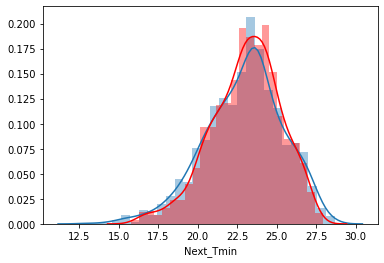

In [37]:
model_cv = KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
model_cv.fit(X_train_knn, y_train)
pred_cv = model.predict(X_test_knn)
sns.distplot(y_test)
sns.distplot(pred_cv, color='red')

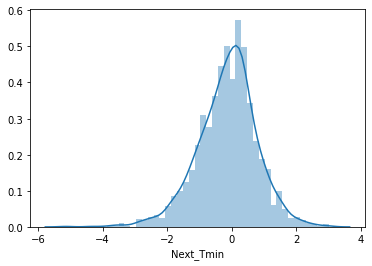

In [38]:
sns.distplot(y_test-pred_cv)